# _2_. 두 모델 구성

* A : IMDB -> CNN용 임베딩/ LSTM용 임베딩 -> 감성분석
* B : IMDB -> 임베딩 -> CNN, LSTM 모델 -> 감성분석

---

> *고통받았다* : `nan`
- 엄밀히 보면 `발산`이라고 보기는 어렵고, 수학적으로 계산할 수 없는 값일 것. 가중치 확인했을 때 전부 다 `nan`이었으니까. 찾아보다 보니까 LSTM에 `relu` activation 줬다. 왜 그랬을까.
    - RMSprop 쓰면 처음부터 nan.
    - LSTM Flatten 해주면 `nan`까지는 안 가던데?
- 보통 데이터 문제
- `X_Dense = Dense(n_hidden, activation='relu')(X_Pool) # relu가 0이 나오나? : 그건 아닐거다`


## 2.0. 모듈, 데이터

In [1]:
# 모듈 불러오기
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D # CNN
from tensorflow.keras.layers import Bidirectional, LSTM # LSTM
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import sys

np.set_printoptions(threshold=sys.maxsize) # numpy array 출력 길이

In [2]:
# 데이터 불러 오기
max_features = int(input('최대 단어 빈도 설정: '))
(X_train_raw, y_train), (X_test_raw, y_test) = imdb.load_data(num_words=max_features)

최대 단어 빈도 설정: 6000


## 2.1. 두 모델 공통 파라미터

In [4]:
# 공통 파라미터
BATCH = int(input('배치 사이즈 설정: '))
n_embed = int(input('임베딩 차원 설정: '))
n_hidden = int(input('은닉 노드 수 설정: '))
EPOCHS = int(input('학습 횟수 설정: '))

배치 사이즈 설정: 300
임베딩 차원 설정: 64
은닉 노드 수 설정: 128
학습 횟수 설정: 1000


In [5]:
# 최대 문장 길이 설정
def check_len(m, sentences):
    cnt = 0
    for sent in sentences:
        if len(sent) <= m:
            cnt += 1
    
    return f'전체 문장 중 길이가 {m} 이하인 샘플의 비율: {(cnt/len(sentences))*100}'

# 문장 길이 설정: 패딩
for length in range(100, 1000, 50):
    print(check_len(length, X_train_raw))
print()
max_length = int(input('문장 길이 설정: '))

전체 문장 중 길이가 100 이하인 샘플의 비율: 11.288
전체 문장 중 길이가 150 이하인 샘플의 비율: 37.732
전체 문장 중 길이가 200 이하인 샘플의 비율: 57.292
전체 문장 중 길이가 250 이하인 샘플의 비율: 68.688
전체 문장 중 길이가 300 이하인 샘플의 비율: 76.36800000000001
전체 문장 중 길이가 350 이하인 샘플의 비율: 81.93599999999999
전체 문장 중 길이가 400 이하인 샘플의 비율: 86.064
전체 문장 중 길이가 450 이하인 샘플의 비율: 89.184
전체 문장 중 길이가 500 이하인 샘플의 비율: 91.56800000000001
전체 문장 중 길이가 550 이하인 샘플의 비율: 93.308
전체 문장 중 길이가 600 이하인 샘플의 비율: 94.812
전체 문장 중 길이가 650 이하인 샘플의 비율: 95.92399999999999
전체 문장 중 길이가 700 이하인 샘플의 비율: 96.72800000000001
전체 문장 중 길이가 750 이하인 샘플의 비율: 97.432
전체 문장 중 길이가 800 이하인 샘플의 비율: 98.012
전체 문장 중 길이가 850 이하인 샘플의 비율: 98.5
전체 문장 중 길이가 900 이하인 샘플의 비율: 98.832
전체 문장 중 길이가 950 이하인 샘플의 비율: 99.136

문장 길이 설정: 500


## 2.3. [A] 임베딩 따로 한 모델 구성

In [6]:
# 패딩 진행
X_train_A = pad_sequences(X_train_raw, maxlen=max_length)
X_test_A = pad_sequences(X_test_raw, maxlen=max_length)
y_train_A = y_train.copy()
y_test_A = y_test.copy()
print("========== 패딩 후 ==========")
print(f"훈련 데이터: {X_train_A.shape}")
print(f"테스트 데이터: {X_test_A.shape}")

========== 패딩 후 ==========
훈련 데이터: (25000, 500)
테스트 데이터: (25000, 500)


### 0) Input

In [8]:
# 입력층
X_Input = Input(batch_shape=(None, max_length))

### 1) IMDB -> 임베딩 -> CNN

In [9]:
# CNN 네트워크 파라미터 설정
n_filters = int(input('필터 개수 설정: '))
s_filters = int(input('커널 사이즈 설정: '))

# CNN 네트워크 레이어 구성
X_Embed_CNN = Embedding(input_dim=max_features, output_dim=n_embed, input_length=max_length)(X_Input)
X_Embed_CNN_2 = Dropout(0.2)(X_Embed_CNN) # CNN 최종 임베딩
X_Conv = Conv1D(filters=n_filters, kernel_size=s_filters, strides=1, padding='same', activation='relu')(X_Embed_CNN_2)
X_Pool = GlobalMaxPooling1D()(X_Conv)
X_Dense = Dense(n_hidden, activation='relu')(X_Pool) # relu가 0이 나오나?: 아님.
X_Dense_2 = Dropout(0.5)(X_Dense)
X_Flatten = Flatten()(X_Pool)

# CNN 네트워크 구성
cnn_model = Model(X_Input, X_Flatten)
cnn_embed_model = Model(X_Input, X_Embed_CNN_2)

# CNN 네트워크 확인
print("========== CNN 모델 전체 구조 확인 ==========")
print(cnn_model.summary())
print()
print("========== CNN 임베딩 모델 구조 확인 ==========")
print(cnn_embed_model.summary())
print()

필터 개수 설정: 300
커널 사이즈 설정: 3
========== CNN 모델 전체 구조 확인 ==========
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 64)           384000    
_________________________________________________________________
dropout (Dropout)            (None, 500, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 300)          57900     
_________________________________________________________________
global_max_pooling1d (Global (None, 300)               0         
_________________________________________________________________
flatten (Flatten)            (None, 300)               0         
Total params: 441,900
Trainable params: 441,900
Non-trainable 

### 2) IMDB -> 임베딩 -> LSTM
  
LSTM 절대로 activation에 RELU 안 된다.

In [10]:
# LSTM 모델 레이어 구성
X_Embed_LSTM = Embedding(input_dim=max_features, output_dim=n_embed, input_length=max_length)(X_Input)
X_Embed_LSTM_2 = Dropout(0.2)(X_Embed_LSTM) # LSTM 최종 임베딩
X_LSTM = Bidirectional(LSTM(n_hidden, return_sequences=True))(X_Embed_LSTM_2) ###### LSTM에 왜 relu를 넣어 놨니ㅠㅠ
X_LSTM = Flatten()(X_LSTM)

# LSTM 모델 구성
lstm_model = Model(X_Input, X_LSTM)
lstm_embed_model = Model(X_Input, X_Embed_LSTM_2)

# 컴파일
print("========== LSTM 모델 전체 구조 확인 ==========")
print(lstm_model.summary())
print()
print("========== LSTM 임베딩 모델 구조 확인 ==========")
print(lstm_embed_model.summary())
print()

========== LSTM 모델 전체 구조 확인 ==========
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 64)           384000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 256)          197632    
_________________________________________________________________
flatten_1 (Flatten)          (None, 128000)            0         
Total params: 581,632
Trainable params: 581,632
Non-trainable params: 0
_________________________________________________________________
None

========== LSTM 임베딩 모델 구조 확인 ==========
Model: "model_3"
_________________

### 3) 네트워크 연결

In [11]:
# 두 층 concat
X_merge = Concatenate()([X_Flatten, X_LSTM])
y_output = Dense(1, activation='sigmoid')(X_merge)

model = Model(X_Input, y_output)

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001))
print("========== 전체 모델 구조 확인 ==========")
print(model.summary())

========== 전체 모델 구조 확인 ==========
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 64)      384000      input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 500, 64)      0           embedding[0][0]                  
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 500, 64)      384000      input_1[0][0]                    
__________________________________________________________

### 4) 모델 학습

loss 음수이거나 0이거나. binary니까 keras가 알아서 로그 속에서는 처리해주는데? binary crosss entropy

- 0.001 : loss `nan` 실화인가?'
- 0.01

In [12]:
# 모델 학습
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
hist_A = model.fit(X_train_A, y_train_A,
                   batch_size=BATCH,
                   epochs=EPOCHS,
                   validation_data=(X_test_A, y_test_A),
                   callbacks=[es])

Epoch 1/1000
84/84 [==============================] - 18s 219ms/step - loss: 0.4442 - val_loss: 0.2955
Epoch 2/1000
84/84 [==============================] - 17s 208ms/step - loss: 0.2378 - val_loss: 0.2948
Epoch 3/1000
84/84 [==============================] - 17s 208ms/step - loss: 0.1841 - val_loss: 0.2917
Epoch 4/1000
84/84 [==============================] - 17s 208ms/step - loss: 0.1677 - val_loss: 0.3219
Epoch 5/1000
84/84 [==============================] - 18s 209ms/step - loss: 0.1190 - val_loss: 0.3669
Epoch 6/1000
84/84 [==============================] - 18s 208ms/step - loss: 0.0796 - val_loss: 0.4130
Epoch 7/1000
84/84 [==============================] - 17s 207ms/step - loss: 0.0471 - val_loss: 0.5822
Epoch 8/1000
84/84 [==============================] - 17s 208ms/step - loss: 0.0324 - val_loss: 0.5567
Epoch 00008: early stopping


### 5) 모델 성능 확인

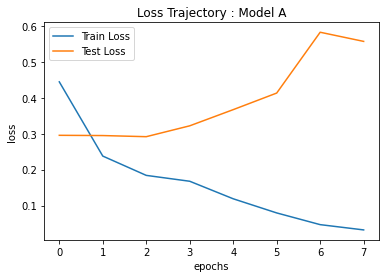

In [13]:
# plot loss
plt.plot(hist_A.history['loss'], label='Train Loss')
plt.plot(hist_A.history['val_loss'], label='Test Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Loss Trajectory : Model A')
plt.show()

In [14]:
# 예측 및 결과 확인: Deprecation Warning 주의
y_train_pred = model.predict(X_train_A)
y_test_pred = model.predict(X_test_A)
y_train_pred = np.reshape(np.where(y_train_pred > 0.5, 1, 0), y_train.shape)
y_test_pred = np.reshape(np.where(y_test_pred > 0.5, 1, 0), y_test.shape)
print(f"Train Accuracy: {accuracy_score(y_train_A, y_train_pred)}")
print(f"Test Accuracy: {accuracy_score(y_test_A, y_test_pred)}")

Train Accuracy: 0.99728
Test Accuracy: 0.8656


### 6) 임베딩 벡터 확인

In [15]:
sample_sent = X_train_A[0]
print(sample_sent)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [16]:
cnn_res = cnn_embed_model.predict(sample_sent.reshape(-1, max_length))
lstm_res = lstm_embed_model.predict(sample_sent.reshape(-1, max_length))

In [17]:
print("========== CNN 모델 임베딩 결과 ============")
print(cnn_res.reshape(max_length, -1))
print()
print("========== LSTM 모델 임베딩 결과 ============")
print(lstm_res.reshape(max_length, -1))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  -3.45326178e-02  4.25888449e-02 -3.17482874e-02 -9.51436628e-03
   3.26422863e-02  4.12402898e-02 -5.38401958e-03 -3.54782119e-02
   1.82549637e-02  1.55190518e-02 -3.64842638e-02  2.31273822e-03
  -2.09941398e-02  2.20273435e-02  3.21304984e-02 -1.70467943e-02
  -7.75131746e-04 -1.43383620e-02  3.64461318e-02 -3.31726372e-02
  -2.42105369e-02  2.04471257e-02 -4.07414809e-02  2.42186300e-02
   1.07407598e-02 -1.89711507e-02 -3.75383087e-02 -1.34982187e-02]
 [-3.62416264e-03 -1.67276170e-02  8.90267082e-03 -1.17820939e-02
   3.03255394e-02  3.40875462e-02 -3.23437229e-02 -2.14650687e-02
   1.05791353e-02 -2.24900302e-02  4.09620404e-02  3.91013362e-03
   2.88158166e-03  1.05869966e-02 -1.74836069e-02 -5.76853752e-03
   2.02388689e-02 -3.22874868e-03  1.85643565e-02  3.01919580e-02
   6.02920307e-03 -5.90815907e-03 -2.37446930e-02 -6.96377037e-03
  -3.63888852e-02 -3.74495052e-02 -1.66319162e-02 -3.61550711e-02
  -8.38207547e-03 -1.77912209e-02 -2.68

## 2.4. [B] 임베딩 같이 한 모델 구성


In [18]:
# 패딩 진행
X_train_B = pad_sequences(X_train_raw, maxlen=max_length)
X_test_B = pad_sequences(X_test_raw, maxlen=max_length)
y_train_B = y_train.copy()
y_test_B = y_test.copy()
print("========== 패딩 후 ==========")
print(f"훈련 데이터: {X_train_B.shape}")
print(f"테스트 데이터: {X_test_B.shape}")

========== 패딩 후 ==========
훈련 데이터: (25000, 500)
테스트 데이터: (25000, 500)


### 1) IMDB -> 임베딩

In [19]:
# 임베딩 레이어 구성
X_Input = Input(batch_shape=(None, max_length))
X_Embed = Embedding(input_dim=max_features, output_dim=n_embed, input_length=max_length)(X_Input)
X_Embed_2 = Dropout(0.2)(X_Embed) # 최종 임베딩

# 임베딩 모델 구조 확인
embed_model = Model(X_Input, X_Embed_2)
print("========== 임베딩 모델 구조 확인 ==========")
print(embed_model.summary())

========== 임베딩 모델 구조 확인 ==========
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 64)           384000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 64)           0         
Total params: 384,000
Trainable params: 384,000
Non-trainable params: 0
_________________________________________________________________
None


### 2) 임베딩 -> CNN

In [20]:
# CNN 네트워크 파라미터 설정
n_filters = int(input('컨볼루션 필터 개수 설정: '))
s_filters = int(input('컨볼루션 필터 사이즈 설정: '))

# CNN 네트워크 레이어 구성
X_Conv = Conv1D(filters=n_filters, kernel_size=s_filters, strides=1, padding='valid', activation='relu')(X_Embed_2)
X_Pool = GlobalMaxPooling1D()(X_Conv)
X_Dense = Dense(n_hidden, activation='relu')(X_Pool)
X_Dense_2 = Dropout(0.5)(X_Dense)
X_Flatten = Flatten()(X_Dense_2)

# CNN 네트워크 확인
cnn_model = Model(X_Input, X_Flatten)
print("========== CNN 모델 전체 구조 확인 ==========")
print(cnn_model.summary())

컨볼루션 필터 개수 설정: 300
컨볼루션 필터 사이즈 설정: 3
========== CNN 모델 전체 구조 확인 ==========
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 64)           384000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 498, 300)          57900     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               38528     
__________________________________________________

### 3) 임베딩 -> LSTM

In [21]:
# LSTM 네트워크 레이어 구성
X_LSTM = Bidirectional(LSTM(n_hidden, return_sequences=True))(X_Embed_2)
X_LSTM = Flatten()(X_LSTM)

# LSTM 네트워크 확인
lstm_model = Model(X_Input, X_LSTM)
print("========== CNN 모델 전체 구조 확인 ==========")
print(lstm_model.summary())

========== CNN 모델 전체 구조 확인 ==========
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 64)           384000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 256)          197632    
_________________________________________________________________
flatten_3 (Flatten)          (None, 128000)            0         
Total params: 581,632
Trainable params: 581,632
Non-trainable params: 0
_________________________________________________________________
None


### 4) 네트워크 연결

In [22]:
# 두 층 concat
X_merge = Concatenate()([X_Flatten, X_LSTM])
y_output = Dense(1, activation='sigmoid')(X_merge)

model = Model(X_Input, y_output)

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001))
print("========== 전체 모델 구조 확인 ==========")
print(model.summary())

========== 전체 모델 구조 확인 ==========
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 500, 64)      384000      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 500, 64)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 498, 300)     57900       dropout_3[0][0]                  
__________________________________________________________

### 5) 모델 학습

In [23]:
# 모델 학습
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
hist_B = model.fit(X_train_B, y_train_B,
                   batch_size=BATCH,
                   epochs=EPOCHS,
                   validation_data=(X_test_B, y_test_B),
                   callbacks=[es])

Epoch 1/1000
84/84 [==============================] - 17s 203ms/step - loss: 0.4425 - val_loss: 0.2945
Epoch 2/1000
84/84 [==============================] - 16s 193ms/step - loss: 0.2326 - val_loss: 0.2783
Epoch 3/1000
84/84 [==============================] - 16s 193ms/step - loss: 0.1891 - val_loss: 0.2955
Epoch 4/1000
84/84 [==============================] - 16s 194ms/step - loss: 0.1540 - val_loss: 0.3026
Epoch 5/1000
84/84 [==============================] - 16s 193ms/step - loss: 0.1144 - val_loss: 0.3878
Epoch 6/1000
84/84 [==============================] - 16s 194ms/step - loss: 0.0803 - val_loss: 0.4121
Epoch 7/1000
84/84 [==============================] - 16s 193ms/step - loss: 0.0566 - val_loss: 0.5849
Epoch 00007: early stopping


### 6) 모델 성능 확인

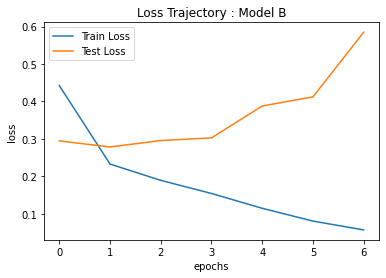

In [24]:
# plot loss
plt.plot(hist_B.history['loss'], label='Train Loss')
plt.plot(hist_B.history['val_loss'], label='Test Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Loss Trajectory : Model B')
plt.show()

In [25]:
# 예측 및 결과 확인
y_train_pred = model.predict(X_train_B)
y_test_pred = model.predict(X_test_B)
y_train_pred = np.reshape(np.where(y_train_pred > 0.5, 1, 0), y_train.shape)
y_test_pred = np.reshape(np.where(y_test_pred > 0.5, 1, 0), y_test.shape)
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}")

Train Accuracy: 0.99292
Test Accuracy: 0.8602


### 7) 임베딩 벡터 확인

In [26]:
sample_sent = X_train_B[0]
print(sample_sent)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [27]:
res = cnn_embed_model.predict(sample_sent.reshape(-1, max_length))

In [28]:
print("========== 한 번에 구성한 모델 임베딩 결과 ============")
print(res.reshape(max_length, -1))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
   3.84321176e-02  1.12635273e-04 -4.35668491e-02 -1.92168467e-02
   5.03144041e-02  4.45067100e-02  9.00142491e-02 -6.06532022e-03
  -3.28318924e-02 -1.55614270e-02  8.47634859e-03  4.11318727e-02
  -1.92447398e-02  1.92446844e-03  1.58659020e-03 -2.03497559e-02
   2.38218158e-02  1.02835093e-02  1.55577960e-04  6.08524829e-02
   1.58874597e-02  4.58811829e-03 -5.84069602e-02 -8.79715383e-03
  -2.71449890e-03  1.04598515e-02 -3.16916197e-03  1.36160880e-01]
 [ 4.83390456e-03 -6.57081930e-03  3.85656692e-02 -3.12090497e-02
   1.48530360e-02  5.86856604e-02  5.99493692e-03  3.80042829e-02
  -5.79881705e-02  6.53044581e-02 -4.10193717e-03  3.02776489e-02
  -2.48433221e-02  4.05996516e-02  3.31937745e-02  7.70355389e-03
   2.14149784e-02  2.34681349e-02  7.75664449e-02  7.67209604e-02
  -5.08933254e-02 -3.47479768e-02 -1.13251489e-02  2.33417656e-02
  -1.83291137e-02 -8.19944516e-02  1.74896531e-02  8.99820551e-02
  -5.29726483e-02  2.12236345e-02 -8.92